In [1]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from matplotlib.pylab import plt
from pandas import DataFrame
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/anaconda3/envs/fastcampus/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/fastcampus/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/fastcampus/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/fastcampus/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def plot_scatter(xy, labels, title=""):
    # scatter plot, dots colored by class value
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels))
    colors = {1:'red', 0:'blue'}
    fig, ax = plt.subplots(figsize=(5,5))
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, \
                   color=colors[key], edgecolor='k', alpha=0.5)
    plt.axis('equal')
    plt.title(title)
    plt.grid()
    plt.show()

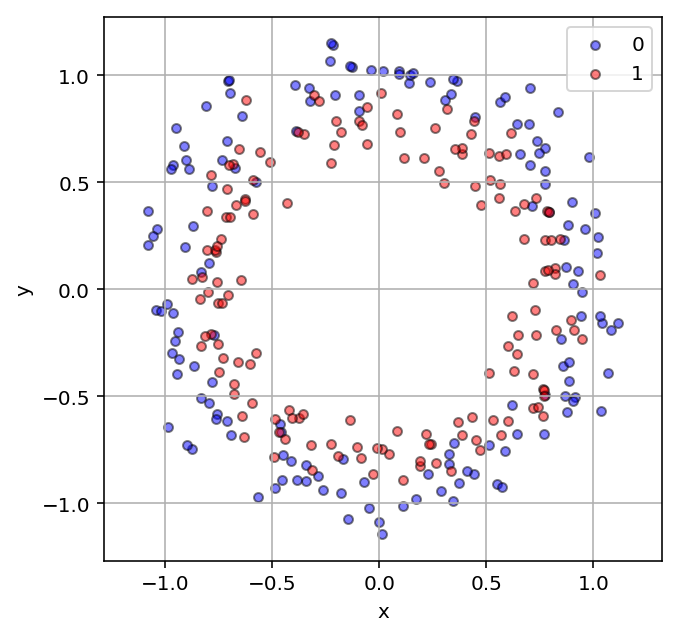

In [3]:
# generate 2d classification dataset
xy, labels = make_circles(n_samples=300, noise=0.1, random_state=417)
plot_scatter(xy, labels)

In [4]:
xy_train, xy_test, labels_train, labels_test  = train_test_split(xy, labels, test_size = 0.3)
print(labels_train.shape)

(210,)


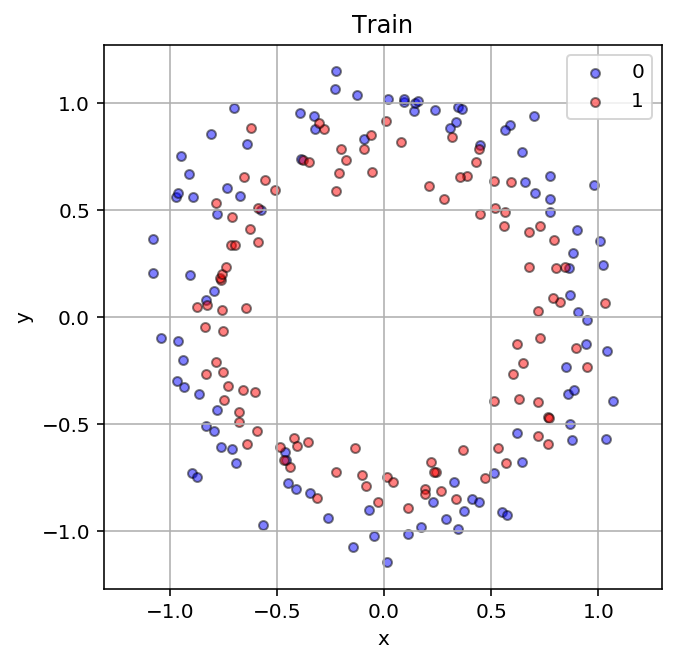

In [5]:
plot_scatter(xy_train, labels_train, title="Train")

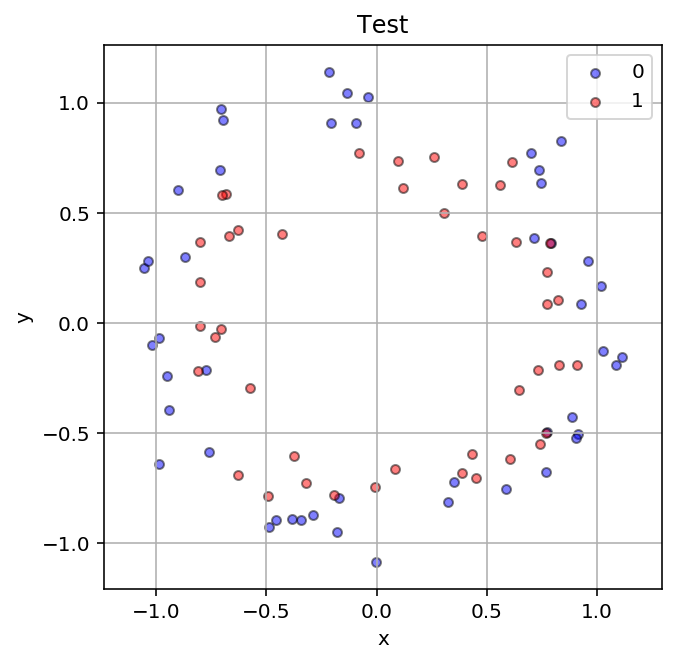

In [6]:
plot_scatter(xy_test, labels_test, title='Test')

In [7]:
def generate_batches(batch_size, features, labels):
    assert len(features) == len(labels)
    outout_batches = []

    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)

    return outout_batches

In [8]:
def plot_model(sess, model, titles):
    train_and_test = [(xy_train, labels_train), (xy_test, labels_test)]
    xx, yy = np.meshgrid(np.linspace(-1.5,1.5), np.linspace(-1.5,1.5))
    prediction = sess.run(model, feed_dict={x: np.array([[xxval, yyval] for xxval, yyval in zip(xx.flatten(), yy.flatten())])})
    Z = prediction.reshape(xx.shape)
    colors = {1:'red', 0:'blue'}
    _, axes = plt.subplots(1, 2, figsize=(8, 4))
    for (xy_, labels_), ax, title in zip(train_and_test, axes, titles):
        df = DataFrame(dict(x=xy_[:,0], y=xy_[:,1], label=labels_.flatten()))
        ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=.9,)
        grouped = df.groupby('label')
        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], edgecolor='k')
        ax.set_xlim([-1.3, 1.3])
        ax.set_ylim([-1.3, 1.3])
        ax.grid(linestyle='--')
        ax.set_title(title)
    plt.show()

## Neural Network Model

1. `tf.layers.dense`
1. `num_hidden1, num_hidden2 = 10, 4` 
1. Activation : `tf.nn.sigmoid`
1. loss : `tf.reduce_sum(- y * tf.log(yhat) - (1-y) * tf.log(1-yhat) )`

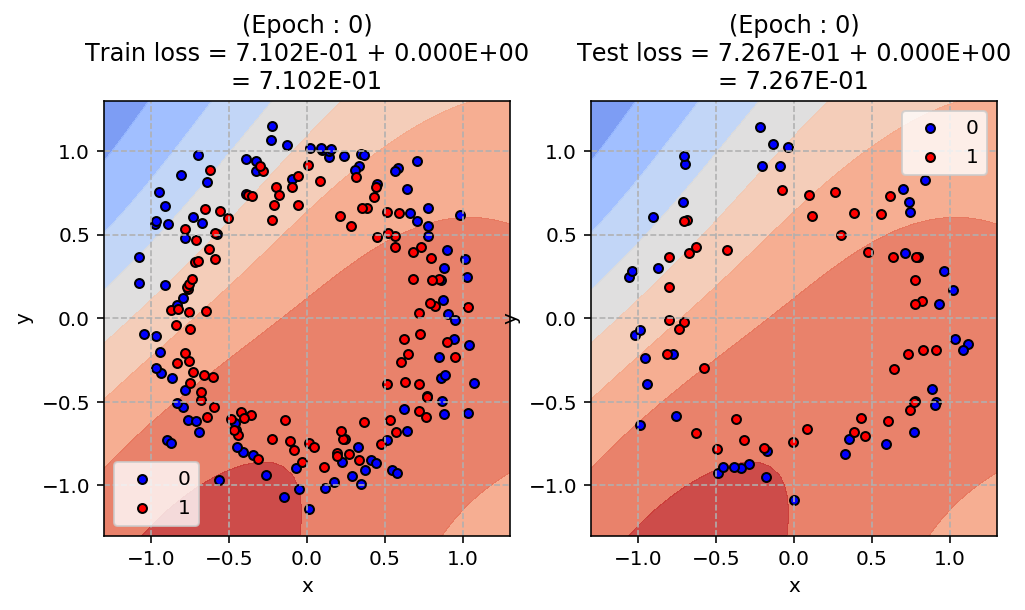

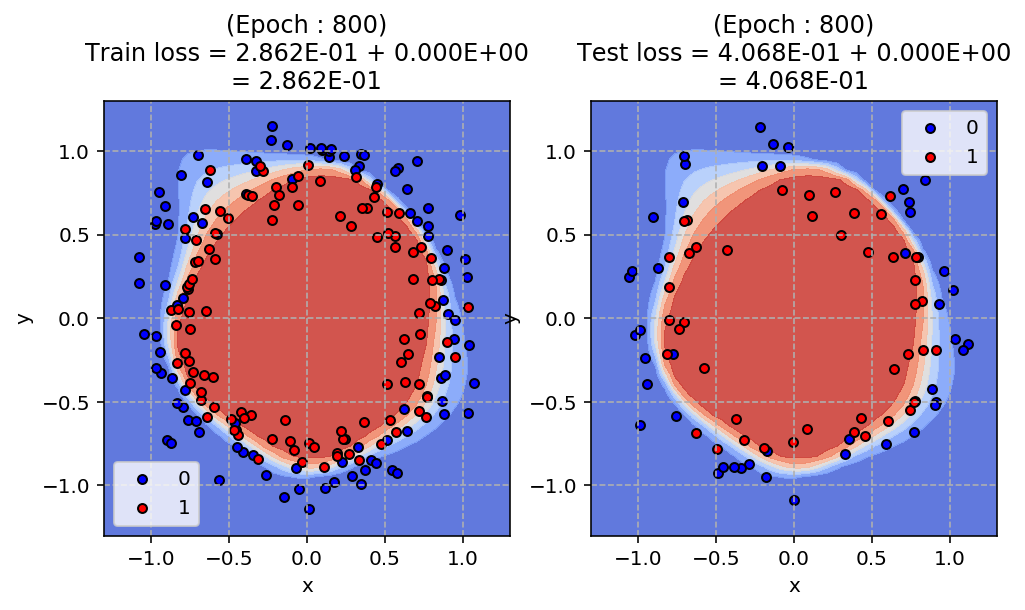

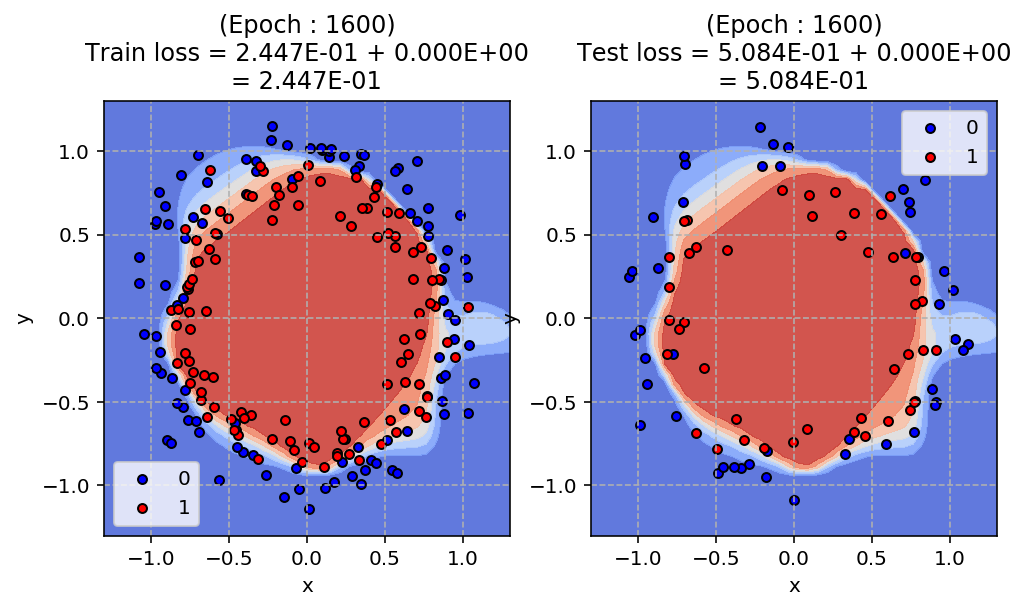

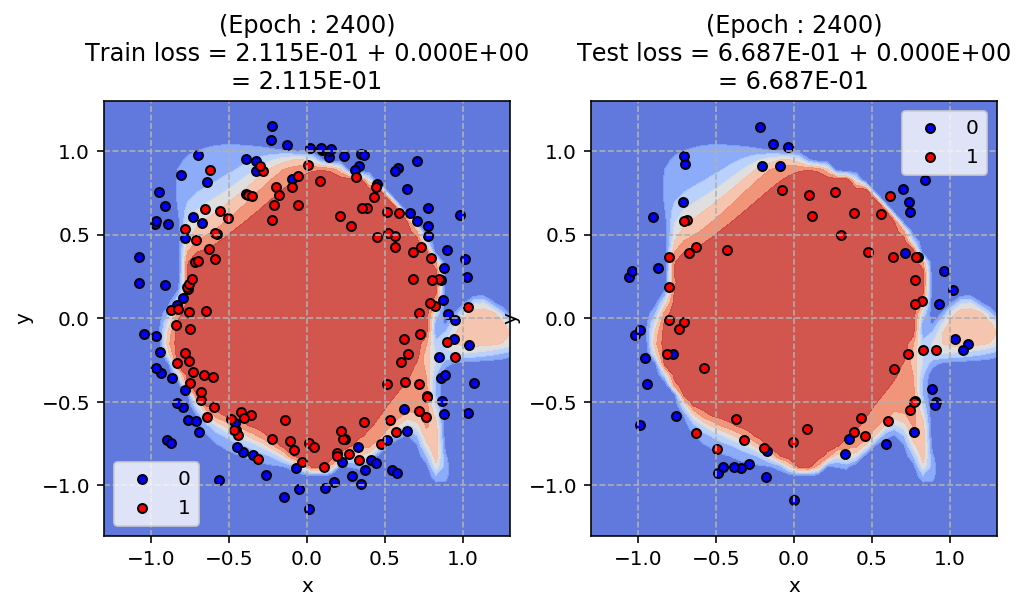

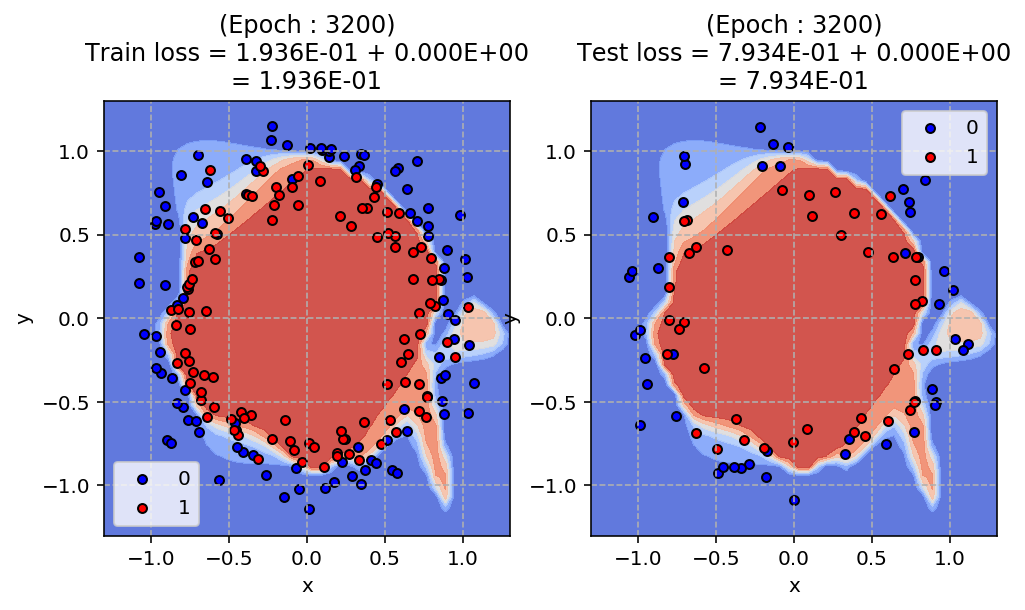

In [9]:
tf.set_random_seed(20180417)
beta = 0.0
num_hidden1, num_hidden2 = 10, 4
x = tf.placeholder(tf.float32, [None, 2])

W1 = tf.Variable(tf.random_normal([2, num_hidden1]))
b1 = tf.Variable(tf.random_normal([num_hidden1]))

W2 = tf.Variable(tf.random_normal([num_hidden1, num_hidden2]))
b2 = tf.Variable(tf.random_normal([num_hidden2]))

W3 = tf.Variable(tf.random_normal([num_hidden2, 1]))
b3 = tf.Variable(tf.random_normal([1]))

hidden1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)
hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, W2) + b2)

yhat = tf.sigmoid(tf.matmul(hidden2, W3) + b3)

y = tf.placeholder(tf.float32, [None, 1])

cross_entropy = tf.reduce_mean(- y * tf.log(yhat) - (1-y) * tf.log(1-yhat) )
l1_regular_loss =  beta * (tf.norm(W1,1) + tf.norm(W2,1) + tf.norm(W3,1))

loss = cross_entropy + l1_regular_loss

lr = 0.01
MaxEpoch = 3201

train = tf.train.AdamOptimizer(lr).minimize(loss)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(MaxEpoch):
    sess.run(train, feed_dict={x:xy_train, y:labels_train.reshape(-1,1)})
    
    if epoch % 800 == 0:
        train_loss, train_loss1, train_loss2 = sess.run([loss, cross_entropy, l1_regular_loss], feed_dict={x:xy_train, y:labels_train.reshape(-1,1)})
        test_loss, test_loss1, test_loss2 = sess.run([loss, cross_entropy, l1_regular_loss], feed_dict={x:xy_test, y:labels_test.reshape(-1,1)})
        plot_model(sess, yhat, ['(Epoch : {1})\nTrain loss = {2:4.3E} + {3:4.3E}\n= {0:4.3E}'.format(train_loss, epoch, train_loss1, train_loss2), \
                                '(Epoch : {1})\nTest loss = {2:4.3E} + {3:4.3E}\n= {0:4.3E}'.format(test_loss, epoch, test_loss1, test_loss2)])

## L1 Regularization

`l2_regular_loss`는 아래 식을 계산해야합니다.
$$
\frac{\beta}{2}\sum_{ij} |W^1_{ij}| + \frac{\beta}{2}\sum_{ij} |W^2_{ij}| + \frac{\beta}{2}\sum_{ij} |W^3_{ij}|
$$

다음 함수를 참고하세요
- `tf.norm(, 1)`

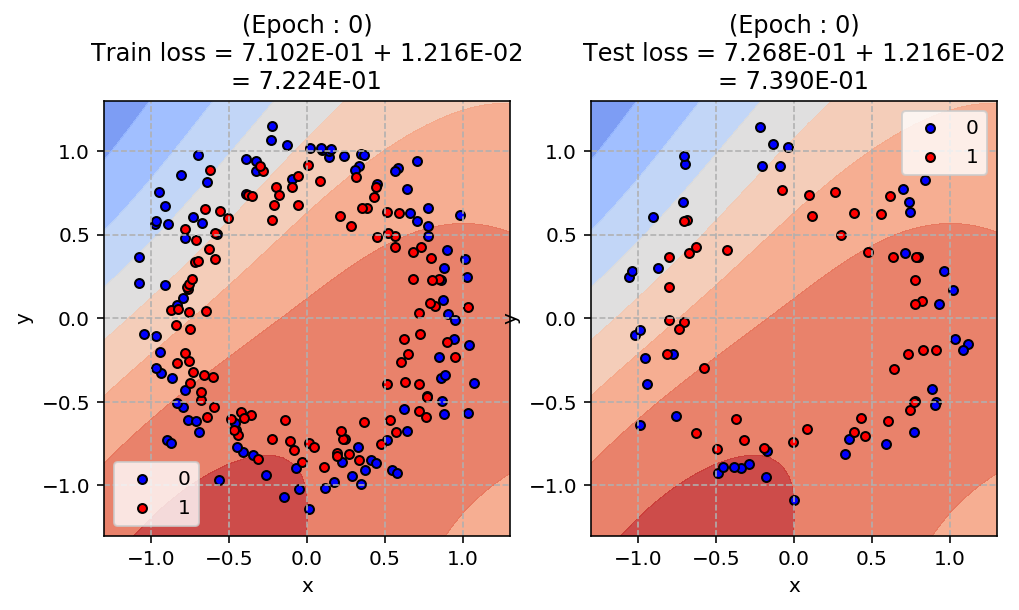

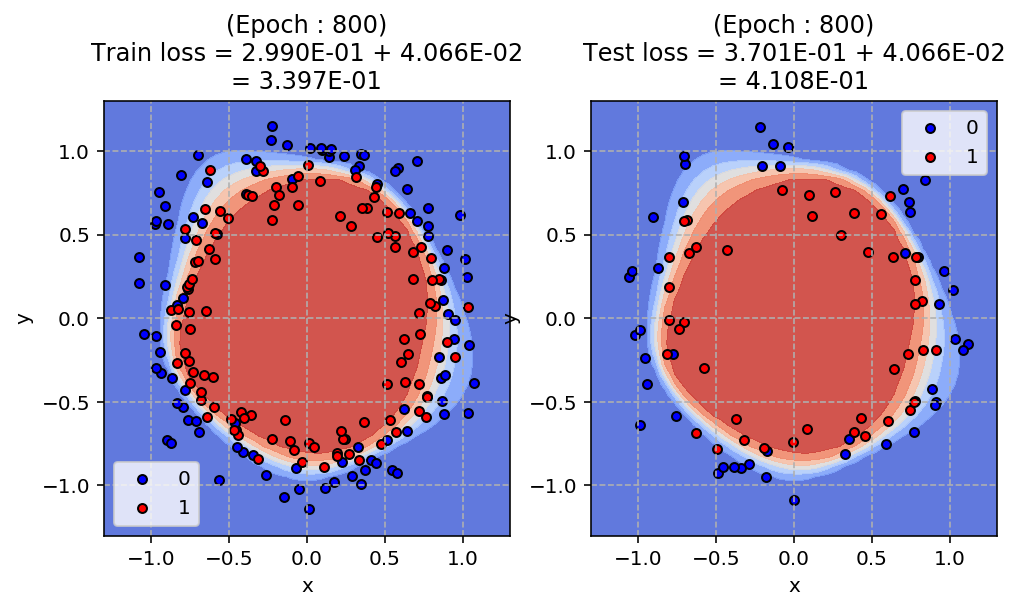

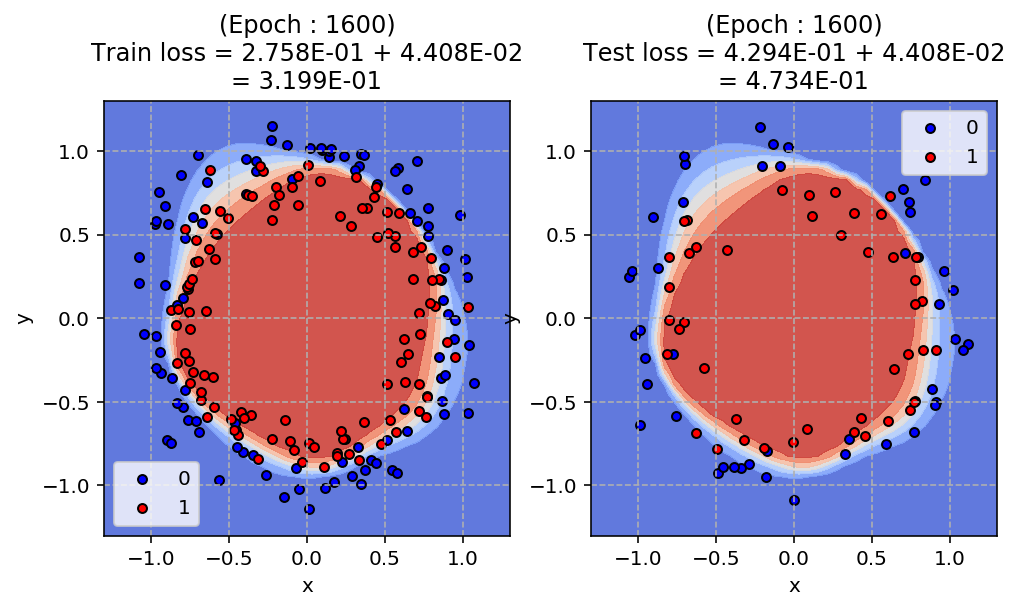

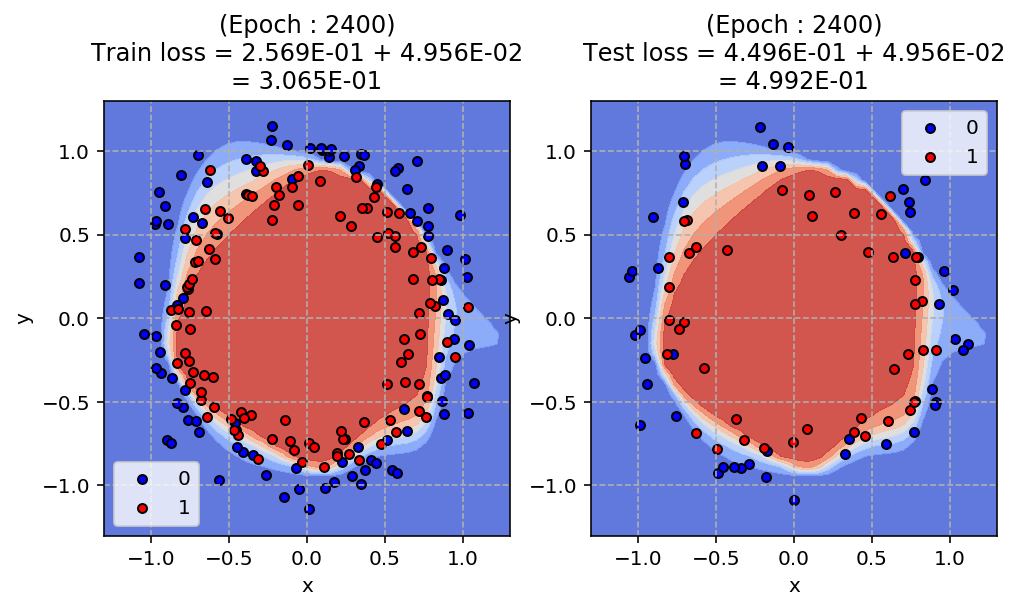

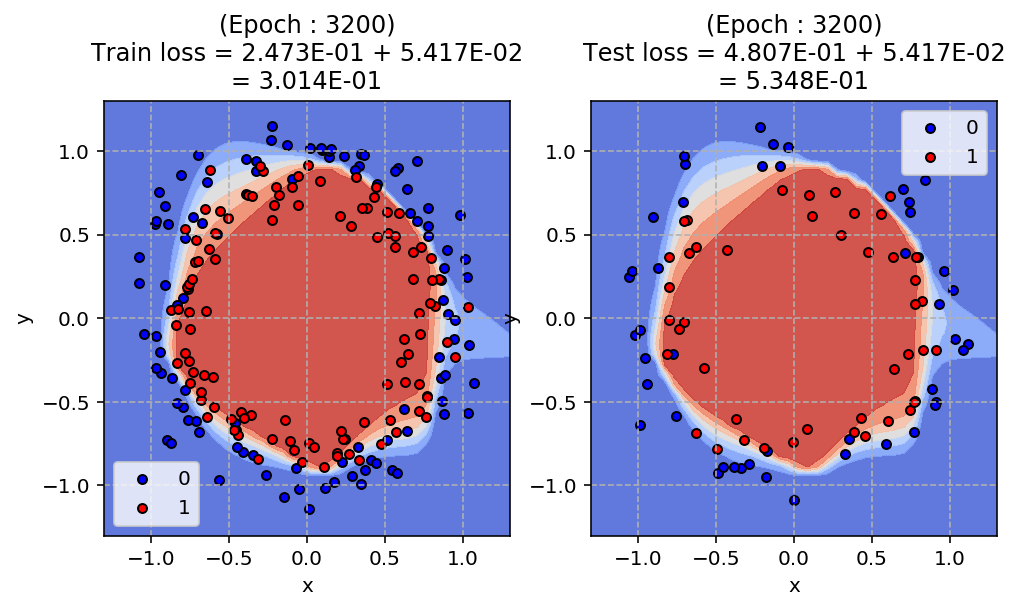

In [10]:
beta = 5E-4
cross_entropy = tf.reduce_mean(- y * tf.log(yhat) - (1-y) * tf.log(1-yhat) )
# TODO 1
l1_regular_loss =  beta /2* (tf.norm(W1,1) + tf.norm(W2,1) + tf.norm(W3,1))

loss = cross_entropy + l1_regular_loss

train = tf.train.AdamOptimizer(lr).minimize(loss)

MaxEpoch = 3201

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(MaxEpoch):
    sess.run(train, feed_dict={x:xy_train, y:labels_train.reshape(-1,1)})
    
    if epoch % 800 == 0:
        train_loss, train_loss1, train_loss2 = sess.run([loss, cross_entropy, l1_regular_loss], feed_dict={x:xy_train, y:labels_train.reshape(-1,1)})
        test_loss, test_loss1, test_loss2 = sess.run([loss, cross_entropy, l1_regular_loss], feed_dict={x:xy_test, y:labels_test.reshape(-1,1)})
        plot_model(sess, yhat, ['(Epoch : {1})\nTrain loss = {2:4.3E} + {3:4.3E}\n= {0:4.3E}'.format(train_loss, epoch, train_loss1, train_loss2), \
                                '(Epoch : {1})\nTest loss = {2:4.3E} + {3:4.3E}\n= {0:4.3E}'.format(test_loss, epoch, test_loss1, test_loss2)])